### Experiment: Multi-Objective - Variance of True Probablity and Private OOB score

#### Aim

The objective of the **individual** is to simply increase variance added per row to the **population's** true_probablity per row and at the same time do good on samples it hasn't seen/trained on (private out of bag error)

true_p variance is being calculated on the entire train set.

While evaluation happens for an ind, I updated the row_mean_variance because of that individual once it's evaluation ends. (real time update) 

#### Critism
- The oob score usually is for the entire ensemble and not just one estimator (hence the *private*)
- Still randomness ensues - unseen performance doesn't increase always with each generation.

#### Basics
- [done] Convert into multi objective function and add accuracy measure.
- [done] Try to make the final ensemble out of the pareto front.
- [ ] Add constraints to the GPs output.
- [done] OOB instead of internal train-test split.
     - In this case mean_p will be calculated on the entire train.
     - Nuance is that it's happening per tree.
- [done] Mutation 1/3 shrink, replace etc.     
     


In [3]:
from collections import Counter
def predict_holdout(pop, subspace=False):
    forest_predictions = []
    sample_sizes = []
#     print X_train[0]
    for ind_num, individual in enumerate(pop):
        func = toolbox.compile(expr=individual)
    #     print individual
        sample_counts = [int(func(*record)) for record in X_train]
        sample_counts = [max(min(sample_count, max_features), 0) for sample_count in sample_counts]
        sample = []
        for sample_index, sample_count in enumerate(sample_counts):
            sample.extend([sample_index] * sample_count)
        sample = np.array(sample)
        
        if len(sample) == 0:
            continue
        
        sample_sizes.append(X_train[sample].shape[0])

        clf = DecisionTreeClassifier(random_state=34092)
        
        X = X_train[sample]
        y = y_train[sample]
        
        if subspace==True:
            X = pd.DataFrame(X).sample(n=int(np.sqrt(X.shape[1])), axis=1)
            xcols = X.columns
            
        clf.fit(X, y)
        
        if subspace==True:
            predictions = clf.predict(pd.DataFrame(X_test).loc[:,xcols])
        else:
            predictions = clf.predict(X_test)
        forest_predictions.append(predictions)
    y_pred = np.array(
    [Counter(instance_forest_predictions).most_common(1)[0][0] for instance_forest_predictions in zip(*forest_predictions)])
    
    return np.sum(y_test == y_pred)*1.0 / len(y_test)

In [74]:
import operator
import itertools
import numpy as np

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.datasets import load_digits
from sklearn.cross_validation import train_test_split

from functools import partial

import pandas as pd

np.seterr(all='raise')

dataset = 'GAMETES'

if dataset == 'digit':
    digits = load_digits()
    data_features, data_labels = digits.data, digits.target

if dataset == 'GAMETES':
    df = pd.read_csv('GAMETES-easy-4x2-way_her-0.4_pop-1600_attribs-100_discrete.csv', delimiter='\t')
    data_features, data_labels = df.iloc[:,:-1].values, df.iloc[:, -1].values

print data_features.shape



# X_train_tot, X_test_tot, y_train_tot, y_test_tot = train_test_split(data_features, data_labels, stratify=data_labels,
#                                                     train_size=0.75, test_size=0.25)


# X_train, X_test, y_train, y_test = train_test_split(X_train_tot, y_train_tot, stratify=y_train_tot,
#                                                     train_size=0.75, test_size=0.25)


X_train, X_test, y_train, y_test = train_test_split(data_features, data_labels, stratify=data_labels,
                                                    train_size=0.75, test_size=0.25)


# defined a new primitive set for strongly typed GP
pset = gp.PrimitiveSetTyped('MAIN', itertools.repeat(float, data_features.shape[1]), float, 'Feature')

# boolean operators
pset.addPrimitive(operator.and_, [bool, bool], bool)
pset.addPrimitive(operator.or_, [bool, bool], bool)
pset.addPrimitive(operator.not_, [bool], bool)

# floating point operators
# Define a protected division function
def protectedDiv(left, right):
    try: return left / right
    except (ZeroDivisionError, FloatingPointError): return 1.

pset.addPrimitive(operator.add, [float, float], float)
pset.addPrimitive(operator.sub, [float, float], float)
pset.addPrimitive(operator.mul, [float, float], float)
pset.addPrimitive(protectedDiv, [float, float], float)

# logic operators
# Define a new if-then-else function
def if_then_else(in1, output1, output2):
    if in1: return output1
    else: return output2

pset.addPrimitive(operator.lt, [float, float], bool)
pset.addPrimitive(operator.eq, [float, float], bool)
pset.addPrimitive(if_then_else, [bool, float, float], float)

# terminals
pset.addTerminal(False, bool)
pset.addTerminal(True, bool)
for val in np.arange(-10., 11.):
    pset.addTerminal(val, float)

creator.create('FitnessMax', base.Fitness, weights=(1.0,1.0))
creator.create('Individual', gp.PrimitiveTree, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register('expr', gp.genHalfAndHalf, pset=pset, min_=1, max_=3)
toolbox.register('individual', tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)
toolbox.register('compile', gp.compile, pset=pset)



def _random_mutation_operator(individual, expr, pset):
    """Perform a replacement, insert, or shrink mutation on an individual
    Parameters
    ----------
    individual: DEAP individual
        A list of pipeline operators and model parameters that can be compiled by DEAP into a callable function
    Returns
    -------
    fitness: list
        Returns the individual with one of the mutations applied to it
    """
    mutation_techniques = [
        partial(gp.mutUniform, expr=expr, pset=pset),
        partial(gp.mutInsert, pset=pset),
        partial(gp.mutShrink)
    ]
    return np.random.choice(mutation_techniques)(individual)


row_prob = {} # Each key is row index,
row_mean_prob = {}
def update_true_class_variance(pop_):
    
    """
    pop is a list of indiv.
    Each indiv
    """
    global row_prob, row_mean_prob
    row_prob = {} #reset
    row_mean_prob = {}
    
    
    for individual in pop_:
        func = toolbox.compile(expr=individual)
        sample_counts = [int(func(*record)) for record in X_train]
        sample_counts = [max(min(sample_count, max_features), 0) for sample_count in sample_counts]
        sample = []
        for sample_index, sample_count in enumerate(sample_counts):
            sample.extend([sample_index] * sample_count)
        sample = np.array(sample)
        
        if len(sample) == 0:
            continue

        clf = DecisionTreeClassifier(random_state=34092)
        clf.fit(X_train[sample], y_train[sample])

        probas = clf.predict_proba(X_train)
#         print clf.classes_
        for ix, row in enumerate(probas):
#             print row
            try:
                true_p = row[y_train[ix]]
            except:
                true_p = np.nan
            try:
                row_prob[ix].append(true_p)
            except:
                row_prob[ix] = [true_p]
#                 print row_prob[ix]
    
#     print 'row_prob', row_prob
    for key in row_prob.keys():
        row_mean_prob[key] = np.nanmean(row_prob[key])
    
    return    

def evaluate_individual(individual):
    global row_mean_prob
    # Transform the tree expression into a callable function
    func = toolbox.compile(expr=individual)
    sample_counts = [int(func(*record)) for record in X_train]
    sample_counts = [max(min(sample_count, max_features), 0) for sample_count in sample_counts]
    train_sample = []
    test_sample = []
    for sample_index, sample_count in enumerate(sample_counts):
        if sample_count>0:
            train_sample.extend([sample_index] * sample_count)
        else:
            test_sample.extend([sample_index])
    
    train_sample = np.array(train_sample)
    test_sample = np.array(test_sample)
        
    
    if len(train_sample) == 0:
        return (1e-20, 1e-20)    
    elif len(test_sample) == 0: #doubt whether we should punish no samples being left out.
        clf = DecisionTreeClassifier(random_state=34092)
        clf.fit(X_train[train_sample], y_train[train_sample])    
#         score = 0.95*clf.score(X_train[train_sample], y_train[train_sample])
        score = 1e-20
    else:
        clf = DecisionTreeClassifier(random_state=34092)
        clf.fit(X_train[train_sample], y_train[train_sample])
        score = clf.score(X_train[test_sample], y_train[test_sample])

    
    
    ## This should be converted into oobscore.
    ## How will we do this. Based on indices.
    
    
    probas = clf.predict_proba(X_train)
    total_variance = []
    for ix, row in enumerate(probas):
        try:
            true_p = row[y_train[ix]]
        except:
            true_p = 0
        mean_p = row_mean_prob[ix]
        
        
        if true_p>=0.65:
            added_variance = (mean_p - true_p)**2
#             added_variance = 0
        else:
            added_variance = np.nan #Should this be nan?

        
#         if mean_p<=0.5 and true_p>=0.5: #Helps solve the sample
#             added_variance = np.abs(mean_p - true_p)
#         else:
#             added_variance = np.nan
            
            
        total_variance.append(added_variance)
        
    
    mean_variance_added = np.nansum(total_variance) # sum instead of mean | more rows you do good, the better.
    
    update_true_class_variance([individual]) # Experimental, variance should be updated afte each ind is evaluated.
    
    return (mean_variance_added, score)
 
    
cxpb = 0.5
mutpb = 0.5
ngen = 10
mu, lambda_ = 100, 200
verbose = True
holdout_perf = {}
max_features = 3    
    
    
toolbox.register('evaluate', evaluate_individual)
toolbox.register('select', tools.selNSGA2)
# toolbox.register('select', tools.selSPEA2)

toolbox.register('mate', gp.cxOnePoint)
toolbox.register('expr_mut', gp.genFull, min_=0, max_=3)
# toolbox.register('mutate', gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.register('mutate', _random_mutation_operator, expr=toolbox.expr_mut, pset=pset)

population = toolbox.population(n=mu)
# halloffame = tools.HallOfFame(1)



def pareto_eq(ind1, ind2):
    """Function used to determine whether two individuals are equal on the Pareto front
    Parameters
    ----------
    ind1: DEAP individual from the GP population
        First individual to compare
    ind2: DEAP individual from the GP population
        Second individual to compare
    Returns
    ----------
    individuals_equal: bool
        Boolean indicating whether the two individuals are equal on the Pareto front
    """
    return np.all(ind1.fitness.values == ind2.fitness.values)

halloffame = tools.ParetoFront(similar=pareto_eq)
# halloffame = tools.ParetoFront()








stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register('std', np.std)
stats.register('min', np.min)
stats.register('avg', np.mean)
stats.register('max', np.max)

clf = DecisionTreeClassifier(random_state=34092)
clf.fit(X_train, y_train)
print('Base DecisionTreeClassifier accuracy: {}'.format(clf.score(X_test, y_test)))

clf = RandomForestClassifier(random_state=34092, n_estimators=100)
clf.fit(X_train, y_train)
print('Base RandomForestClassifier accuracy: {}'.format(clf.score(X_test, y_test)))

clf = GradientBoostingClassifier(random_state=34092)
clf.fit(X_train, y_train)
print('Base GradientBoostingClassifier accuracy: {}'.format(clf.score(X_test, y_test)))

print('')



logbook = tools.Logbook()
logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])


update_true_class_variance(population)

# Evaluate the individuals with an invalid fitness ~
invalid_ind = [ind for ind in population if not ind.fitness.valid]
fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
for ind, fit in zip(invalid_ind, fitnesses):
    ind.fitness.values = fit

if halloffame is not None:
    halloffame.update(population)

record = stats.compile(population) if stats else {}
logbook.record(gen=0, nevals=len(invalid_ind), **record)
if verbose:
    print(logbook.stream)

# Begin the generational process
for gen in range(1, ngen + 1):
    # Select the next generation individuals
    
    offspring = algorithms.varOr(population, toolbox, lambda_, cxpb, mutpb)

    

    
    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Update the hall of fame with the generated individuals
    if halloffame is not None:
        halloffame.update(offspring)

    # Select the next generation population
    population[:] = toolbox.select(population + offspring, mu)

    update_true_class_variance(population)
    
    # Append the current generation statistics to the logbook
#     fits = pd.DataFrame()
#     fits['score'] = map(lambda x: x.fitness.values[0], population)
#     fits['contrib_variance'] = map(lambda x: x.fitness.values[1], population)
    
    record = stats.compile(population) if stats else {}
    logbook.record(gen=gen, nevals=len(invalid_ind),**record)
    holdout_perf[gen] = predict_holdout(population)
    if verbose:
        print(logbook.stream)
#         print(fits.score.mean())
#         print(fits.contrib_variance.mean())
        print('Performance on hold-out set:', holdout_perf[gen])
str(halloffame[0])

(200, 100)
Base DecisionTreeClassifier accuracy: 0.66
Base RandomForestClassifier accuracy: 0.58
Base GradientBoostingClassifier accuracy: 0.54

gen	nevals	std    	min   	avg     	max     
0  	100   	15.3243	-47.45	-10.5251	0.606061
1  	200   	6.96993	-34.45	-2.70261	0.606061
('Performance on hold-out set:', 0.64000000000000001)
2  	200   	0.298403	-3.9  	-0.0190147	0.75    
('Performance on hold-out set:', 0.5)
3  	200   	0.106089	-1.3  	-0.00275  	0.75    
('Performance on hold-out set:', 0.59999999999999998)
4  	200   	0.0705337	0     	0.005     	1       
('Performance on hold-out set:', 0.56000000000000005)
5  	200   	0.0994987	0     	0.01      	1       
('Performance on hold-out set:', 0.56000000000000005)
6  	200   	0.0994987	0     	0.01      	1       
('Performance on hold-out set:', 0.56000000000000005)
7  	200   	0.0994987	0     	0.01      	1       
('Performance on hold-out set:', 0.52000000000000002)
8  	200   	0.0994987	0     	0.01      	1       
('Performance on hold-out s

'sub(-8.0, Feature0)'

In [55]:
# X_train.shape
len(population)

100

In [69]:
print "Last Gen Holdout", predict_holdout(population, subspace=False)
print "Last Gen w/ Random Subspace Holdout", predict_holdout(population, subspace=True)
print "Pareto w/ Random Subspace Holdout", predict_holdout(halloffame[0:100], subspace=True)
print "Pareto Holdout:", predict_holdout(halloffame[0:100])

Last Gen Holdout 0.54
Last Gen w/ Random Subspace Holdout 0.4
Pareto w/ Random Subspace Holdout 0.54
Pareto Holdout: 0.48


In [12]:
# row_mean_prob

(array([  4.,   3.,   8.,   5.,  22.,  25.,  18.,  37.,  22.,   6.]),
 array([ 0.83 ,  0.847,  0.864,  0.881,  0.898,  0.915,  0.932,  0.949,
         0.966,  0.983,  1.   ]),
 <a list of 10 Patch objects>)

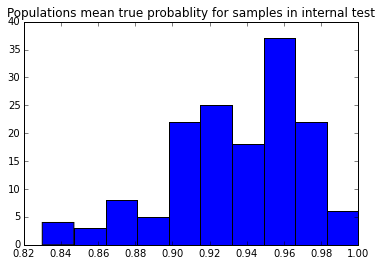

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.title('Populations mean true probablity for samples in internal test')
plt.hist(list(row_mean_prob.values()))
## row_mean_prob is the dictionary which holds per row true_p_variance.

Observation: Ideally, the graph should be as right skewed as possible. 


In [9]:
print("HOF Performance individually: ", predict_holdout([halloffame[0]]))
pop = offspring[:]
# pop = [halloffame[0]]


('HOF Performance individually: ', 0.79157427937915747)


-------
Some statistics on the final population


### Which row repeats and how many times.

In [98]:
def hist_gp_output(individual):
    func = toolbox.compile(expr=individual)
    sample_counts = [func(*record) for record in X_train]
    return sample_counts

In [102]:
X_train.shape

(1009, 64)

In [104]:
%matplotlib inline
pd.Series(hist_gp_output(offspring[1])).value_counts()

-1.000000       35
 0.000000       29
-0.062500        8
 35.000000       8
-0.625000        6
-0.600000        6
-0.750000        6
 44.000000       6
 143.000000      5
 239.000000      5
-3.000000        5
-1.250000        5
-0.250000        5
 104.000000      5
-2.000000        4
-0.166667        4
-0.125000        4
-0.615385        4
 107.000000      4
-1.200000        4
-0.500000        4
-0.571429        4
-12.000000       4
 63.000000       4
 9.000000        4
-0.333333        4
 17.000000       3
-0.400000        3
 11.000000       3
 5.000000        3
                ..
 49.666667       1
 47.860140       1
 1150.666667     1
-1.100000        1
 9.357143        1
 84.333333       1
 46.846154       1
 178.000000      1
 0.666667        1
 28.005495       1
 124.833333      1
 328.142857      1
 175.246154      1
 629.000000      1
 26.333333       1
 141.000000      1
 427.666667      1
 175.400000      1
 64.000000       1
 23.857955       1
 326.600000      1
 21.233766  

In [10]:
import pandas as pd
def row_sampling():
    for ind_num, individual in enumerate(offspring):
        func = toolbox.compile(expr=individual)
    #     print individual
        sample_counts = [int(func(*record)) for record in X_train]
        sample_counts = [max(min(sample_count, max_features), 0) for sample_count in sample_counts]
        sample = []
        for sample_index, sample_count in enumerate(sample_counts):
            sample.extend([sample_index] * sample_count)
        sample = np.array(sample)
        print pd.Series(sample).value_counts().value_counts().index.tolist()
        print '\n'
        if ind_num==50:
            return
    

In [11]:
func = toolbox.compile(expr=offspring[1])

In [12]:
row_sampling()

[]




OverflowError: cannot convert float infinity to integer

In [23]:
forest_predictions = []
subsample_sizes = []
for ind_num, individual in enumerate(offspring):
    func = toolbox.compile(expr=individual)
#     print individual
    sample_counts = [int(func(*record)) for record in X_train]
    sample_counts = [max(min(sample_count, max_features), 0) for sample_count in sample_counts]
    sample = []
    for sample_index, sample_count in enumerate(sample_counts):
        sample.extend([sample_index] * sample_count)
    sample = np.array(sample)
    
    if len(sample) == 0:
        continue
    
    subsample_sizes.append(len(sample))
    
    clf = DecisionTreeClassifier(random_state=34092)
    clf.fit(X_train[sample], y_train[sample])
    predictions = clf.predict(X_test_tot)
    forest_predictions.append(predictions)

ValueError: cannot convert float NaN to integer

In [100]:
from sklearn.metrics import accuracy_score

y_pred = np.array(
    [Counter(instance_forest_predictions).most_common(1)[0][0] for instance_forest_predictions in zip(*forest_predictions)])
np.sum(y_test_tot == y_pred)*1.0 / len(y_test_tot)

0.95565410199556544

In [102]:
pop = offspring[:]
import pandas as pd
fits = pd.DataFrame()
# fits['score'] = map(lambda x: x.fitness.values[0], pop)
fits['contrib_variance'] = [x.fitness.values[0] for x in pop]

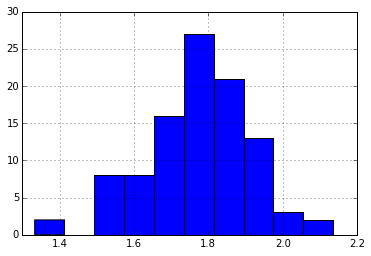

In [103]:
%matplotlib inline
fits.contrib_variance.hist()

3275.66
1516.77295743


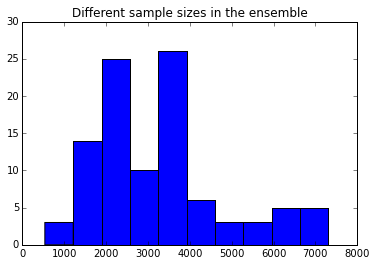

In [104]:
plt.title('Different sample sizes in the ensemble')
plt.hist(subsample_sizes)
print(np.mean(subsample_sizes))
print(np.std(subsample_sizes))


In [14]:

import pandas as pd
print("Mean # of unique labels predicted per sample by the ensemble.", pd.DataFrame(forest_predictions).apply(
    lambda x: len(x.unique()), axis=0).mean())

Mean # of unique labels predicted per sample by the ensemble. 5.35254988914


----

~ ~ ~ end of notebook - rough work follows ~ ~ ~

----

In [475]:
pd.DataFrame(forest_predictions)

,0,1,2,3,4,5,6,7,8,9,...,441,442,443,444,445,446,447,448,449,450
0,6,6,1,0,1,8,2,2,7,4,...,8,8,0,5,2,2,9,9,3,4
1,6,6,1,0,1,8,2,2,7,4,...,8,8,0,5,2,2,9,9,3,4
2,6,6,1,0,1,8,2,2,7,4,...,8,8,0,5,2,2,9,9,3,4
3,6,6,1,0,1,8,2,2,7,4,...,8,8,8,5,2,2,9,9,3,4
4,6,6,1,0,1,8,2,2,7,4,...,8,8,0,5,2,2,9,9,3,4
5,6,6,1,0,1,8,2,2,7,4,...,8,8,0,5,2,2,9,9,3,1
6,6,6,1,0,1,8,2,2,7,4,...,8,8,0,5,2,2,9,9,3,4
7,6,6,1,0,1,8,2,2,7,4,...,8,8,0,5,2,2,9,9,3,4
8,6,6,1,0,1,8,2,2,7,4,...,8,8,0,5,2,2,9,9,3,4
9,6,6,1,0,1,8,2,2,7,4,...,8,8,0,5,2,2,9,9,3,1


In [97]:
from sklearn import __version__

In [98]:
__version__

'0.17.1'

In [80]:
def random_forest_true_p(list_of_estimators):
    
    """
    pop is a list of indiv.
    Each indiv
    """
    row_mean_prob_ = {}
    row_prob_ = {}
    
    for tree in list_of_estimators:
    
        probas = tree.predict_proba(X_train_tot)
#         print clf.classes_
        for ix, row in enumerate(probas):
#             print row
            try:
                true_p = row[y_train_tot[ix]]
            except:
                true_p = np.nan
            try:
                row_prob_[ix].append(true_p)
            except:
                row_prob_[ix] = [true_p]
#                 print row_prob[ix]
    
#     print 'row_prob', row_prob
    for key in row_prob_.keys():
        row_mean_prob_[key] = np.nanmean(row_prob_[key])
    
    return row_mean_prob_
    

In [81]:

clf = RandomForestClassifier(random_state=34092, n_estimators=100)
clf.fit(X_train_tot, y_train_tot)
print('Base RandomForestClassifier accuracy: {}'.format(clf.score(X_test_tot, y_test_tot)))


Base RandomForestClassifier accuracy: 0.982261640798


In [82]:
# mean_dict = random_forest_true_p(clf.estimators_)
mean_dict = random_forest_true_p(clf.estimators_)

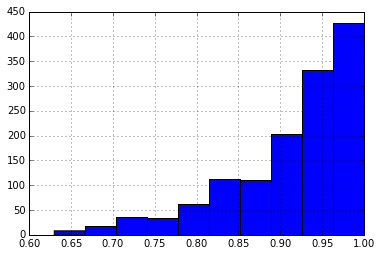

In [83]:
import pandas as pd
pd.Series(mean_dict.values()).hist()

In [55]:
X_train[[1,2,1],[1,2]]

IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (3,) (2,) 

In [60]:
pd.DataFrame(X_train).sample(n=int(np.sqrt(X_train.shape[1])), axis=1).values

array([[  0.,   0.,   0., ...,   2.,   0.,   0.],
       [  0.,   0.,   0., ...,  13.,   1.,  14.],
       [  0.,   0.,   0., ...,  15.,   0.,  16.],
       ..., 
       [  0.,   0.,   0., ...,   4.,   0.,  15.],
       [  0.,   0.,   0., ...,  16.,   0.,   4.],
       [  0.,   0.,   0., ...,  15.,   0.,  15.]])